In [260]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime
import math 

import QuantLib as ql
from scipy.optimize import minimize

dataframe = "SPX"

# NASDAQ

df = pd.DataFrame()
if dataframe != "SPX":

    df = pd.read_csv(r'Nasdaq_optionChain_100821_1915.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')
    df["IV"] = df["IV"]/100
    df["IV (P)"] = df["IV (P)"]/100

    # Remove strikes from Dataframe
    fltr = [140., 145., 150., 155., 160., 165., 170., 175., 180., 185., 190., 195., 200., 210., 220.]
    df = df[df['Strike'].isin(fltr)]
else:
    df = pd.read_csv(r'spx_SABR.csv')
    df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')

    # Remove IV=0 strikes from Dataframe
    fltr = df[df["IV"] <= 0.]["Strike"].unique()
    df = df[~df['Strike'].isin(fltr)]
    df = df[~(df['Strike'] <= 3000)]

maturities = df["Date"].unique()
strikes = df["Strike"].unique()

today = ql.Date(10, 8, 2021) if dataframe != "SPX" else ql.Date(3, 8, 2021)
ql.Settings.instance().evaluationDate = today
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

current_time = pd.Timestamp(year=2021, month=8, day=10, hour=19) if dataframe != "SPX" else pd.Timestamp(year=2021, month=8, day=3, hour=12)
current_price = 188.68 if dataframe != "SPX" else 4300.
ATM_price = 190. if dataframe != "SPX" else 4300.

spot_quote = ql.QuoteHandle(ql.SimpleQuote(current_price))

rate = ql.SimpleQuote(0.00079)

riskFreeCurve = ql.FlatForward(today, ql.QuoteHandle(rate), ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)

vols = [np.array(df[df["Date"] == maturities[m]]["IV"]) for m in range(len(maturities))]

plot_size = (12, 5)

def delta_t(m):

    dt = m - today

    return round(dt/365, 6)

def date_pd_to_ql(date):
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    return ql.Date(day, month, year)

dates = [date_pd_to_ql(d) for d in maturities]
maxDate = (dates[-1] - today) / 365.


In [261]:
#Plot volatility Surface
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, maxDate, 0.1), plot_strikes=strikes, funct='blackVol', title=""):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure(figsize=(25,5))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(title)
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.3)

def plot_smile(date, smiles, market=True, title="", size=(15,5)):

    market_vols = vols[dates.index(date)]

    fig, ax = plt.subplots(figsize=size)
    for smile in smiles:
        ax.plot(strikes, smile[0], label=smile[1])
    if market:
        ax.plot(strikes, market_vols, "rX", label="Actual")
        ax.plot([ATM_price], market_vols[strikes.tolist().index(ATM_price)], "o", label="ATM")
    ax.set_title(title)
    ax.set_xlabel("Strikes", size=12)
    ax.set_ylabel("Vols", size=12)
    legend = ax.legend(loc="upper right")

# Plot Volatility Smile Comparisons

def smiles_comparison(models, heston_models=[], points=(.2, .5, .75, 1)):
        for i in [round((len(dates)-1) * x) for x in points]:
                tenor = dates[i]
                l = [([model.vol_surface.blackVol(tenor, s) for s in strikes], model.label) for model in models]
                if len(heston_models) > 0:
                        l.extend([([x.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston" ) for x in heston_models])

                plot_smile(tenor, l, title="Volatility Smile for options expiring on {}".format(tenor))


In [262]:
#CALIBRATE VOLATILITY SURFACE

class SABRSmile:
    def __init__(self, date, shift=0, beta=1, method="normal", fwd=current_price):
        self.date = date
        self.expiryTime = delta_t(self.date)
        self.marketVols = vols[dates.index(self.date)]
        self.shift = shift
        self.fwd = fwd
        self.alpha=None; self.beta = beta; self.nu=None; self.rho=None
        self.method = method
        self.current_price = current_price
        self.newVols = None
        self.error = None

    def initialize(self):
        cons = (
        {'type': 'ineq', 'fun': lambda x: x[0]},
        # {'type': 'ineq', 'fun': lambda x: 0.99 - x[1]},
        # {'type': 'ineq', 'fun': lambda x: x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: .99 - x[3]**2}
        )

        x = self.set_init_conds()

        result = minimize(self.f, x, constraints=cons, method="SLSQP")
        self.error = result['fun']
        [self.alpha, self.beta, self.nu, self.rho] = result['x']

        self.newVols = [self.vols_by_method(strike, self.alpha, self.beta, self.nu, self.rho) for strike in strikes]

    def set_beta(self):
        return self.beta
    
    def set_init_conds (self):
        if self.beta >= .5:
            return [.1, self.set_beta(), .1, .1]
        else:
            return [.5, self.set_beta(), .4, -.9]

    def vols_by_method(self, strike, alpha, beta, nu, rho):
        if method == "floch-kennedy":
            return ql.sabrFlochKennedyVolatility(strike + self.shift, self.fwd + self.shift, self.expiryTime, alpha, beta, nu, rho)
        else:
            return ql.sabrVolatility(strike + self.shift, self.fwd + self.shift, self.expiryTime, alpha, beta, nu, rho)

    def f(self, params):

        alpha, beta, nu, rho = params

        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        beta = self.set_beta()
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) # Avoid rhp going < -1.0
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([self.vols_by_method(strike, alpha, beta, nu, rho) for strike in strikes])

        self.error = ((vols - np.array(self.marketVols))**2 ).mean() **.5

        return self.error


class SABRVolatilitySurface:
    def __init__(self, method="normal", beta=1, shift=0, fwd=current_price, label=""):
        self.method = method
        self._beta = beta
        self.shift = shift
        self.fwd = fwd
        self.label = label

        self.initialize()

    def initialize(self):
        self.vol_surface_vector, self.errors, self.alpha, self.beta, self.nu, self.rho = [], [], [], [], [], []
        self.SABRVolMatrix, self.SABRVolDiffMatrix = (ql.Matrix(len(strikes), len(dates)), ql.Matrix(len(strikes), len(dates)))
        
        for i, d in enumerate(dates):
            volSABR = SABRSmile(date=d, beta=self._beta, shift=self.shift, method=self.method, fwd=self.fwd)
            volSABR.initialize()

            self.alpha.append(volSABR.alpha)
            self.beta.append(volSABR.beta)
            self.nu.append(volSABR.nu)
            self.rho.append(volSABR.rho)
            
            self.errors.append(volSABR.error)

            smile = volSABR.newVols

            self.vol_surface_vector.extend(smile)

            #constructing the SABRVolatilityMatrix
            for j in range(len(smile)):
                self.SABRVolMatrix[j][i] = smile[j]
                self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]
            
            self.vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, self.SABRVolMatrix, day_count)
            self.vol_surface.enableExtrapolation()

    def to_dataframe(self):
        d = {'alpha': self.alpha, 'beta': self.beta, 'nu': self.nu, 'rho': self.rho}
        return pd.DataFrame(data=d, index=dates)


# Backbone modelling for SABR
def SABR_backbone_plot (beta = 1, fixes = (.95, 1, 1.14, 1.24), tenor = dates[2]):
    l = []
    for i in fixes:
        vol_surface = SABRVolatilitySurface(method="normal", shift=0, beta=beta, fwd=current_price * i)
        SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, vol_surface.SABRVolMatrix, day_count)
        SABR_vol_surface.enableExtrapolation()

        l.append( ([SABR_vol_surface.blackVol(tenor, s) for s in strikes], "fwd = {}".format(current_price * i) ) )
        
    plot_smile(tenor, l, market=False, title="backbone, beta = {}, {}".format(beta, tenor))

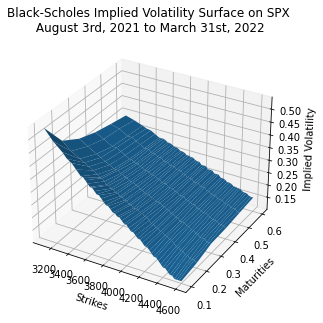

In [263]:
# BLACK VOLATILITY SURFACE

volMatrix = ql.Matrix(len(vols[0]), len(vols))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

black_var_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface.enableExtrapolation()

title = "Black-Scholes Implied Volatility Surface on {}\n {} to {}".format(dataframe, today, dates[-1])
plot_vol_surface(vol_surface=black_var_surface, plot_strikes=strikes, funct='blackVol', title=title)

alpha  beta         nu       rho
August 6th, 2021      0.312154   1.0  35.877732 -0.949437
August 9th, 2021      0.144839   1.0  12.750160 -0.941061
August 11th, 2021     0.155785   1.0  10.071539 -0.916844
August 13th, 2021     0.159056   1.0   7.824145 -0.877914
August 16th, 2021     0.152667   1.0   6.853089 -0.875518
August 20th, 2021     0.154230   1.0   6.920062 -0.875457
August 23rd, 2021     0.160891   1.0   4.677562 -0.844072
August 25th, 2021     0.164678   1.0   4.438983 -0.851249
August 27th, 2021     0.173514   1.0   4.164466 -0.861505
September 10th, 2021  0.171975   1.0   3.173879 -0.829655
September 17th, 2021  0.176632   1.0   2.791151 -0.856691
September 24th, 2021  0.182093   1.0   2.613068 -0.862784
September 30th, 2021  0.180524   1.0   2.483103 -0.840531
October 15th, 2021    0.184770   1.0   2.226143 -0.855385
October 29th, 2021    0.187140   1.0   2.079441 -0.844211
November 19th, 2021   0.191819   1.0   1.810862 -0.862500
November 30th, 2021   0.191645   1.0   1.716384 -0.877298
December 17th, 2021   0.195519   1.0   1.593567 -0.879903
January 31st, 2022    0.202545   1.0   1.421822 -0.913534
March 31st, 2022      0.210345   1.0   1.211645 -0.965001

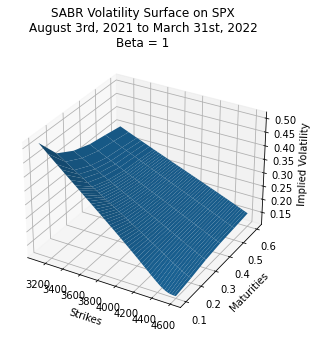

In [264]:
#SABR VOLATILITY SURFACE

volatility_surface = SABRVolatilitySurface()
SABRVolMatrix = volatility_surface.SABRVolMatrix

SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, SABRVolMatrix, day_count)
SABR_vol_surface.enableExtrapolation()

title = "SABR Volatility Surface on {}\n{} to {}\nBeta = 1".format(dataframe, today, dates[-1])
plot_vol_surface(vol_surface=SABR_vol_surface, title=title)

volatility_surface.to_dataframe()

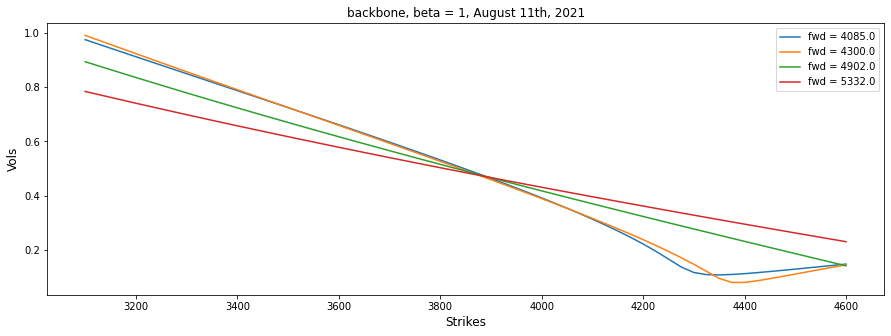

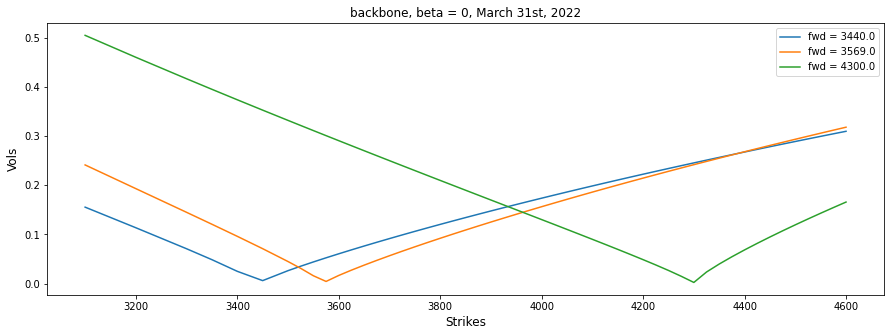

In [265]:
# Normal SABR Backbone modelling

SABR_backbone_plot()
SABR_backbone_plot(beta = 0, fixes = (.8, .83, 1), tenor = dates[-1])

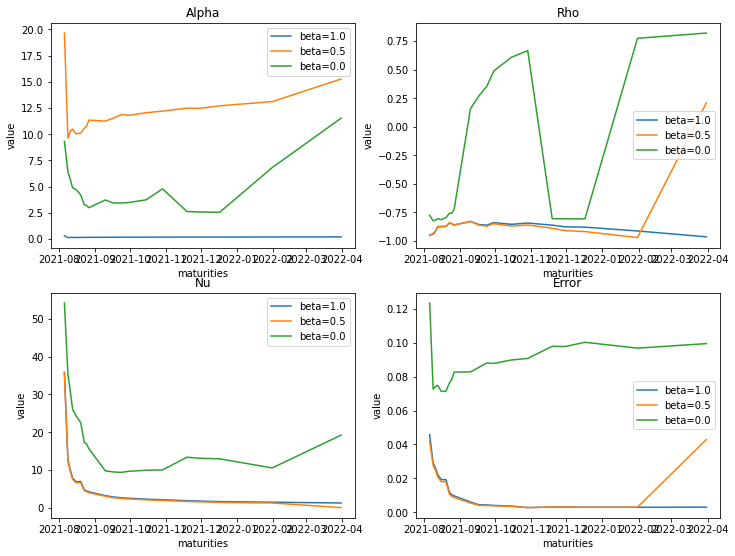

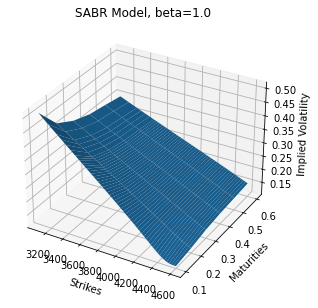

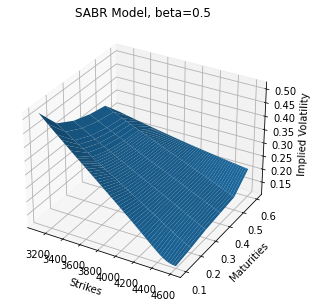

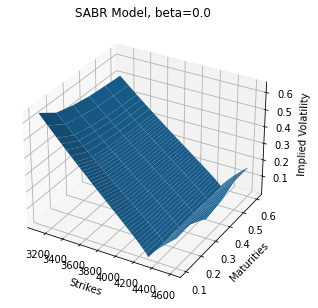

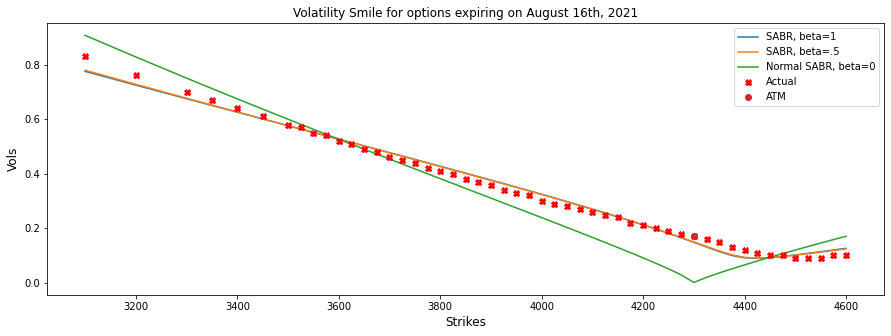

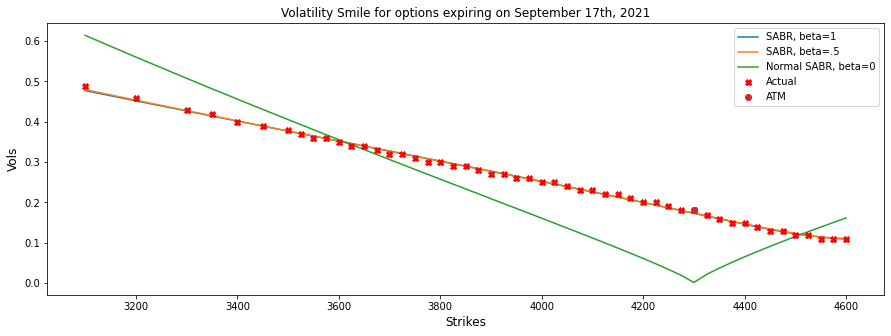

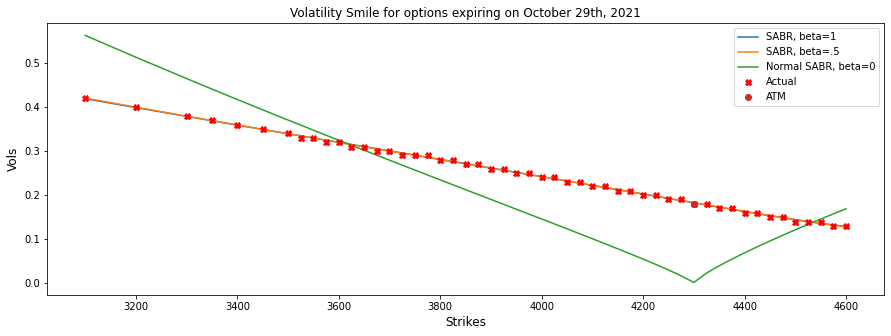

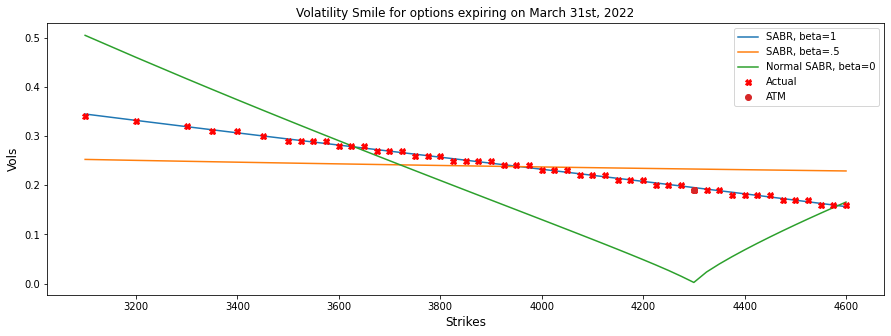

In [266]:
# Normal SABR Volatility model

SABR_beta1 = SABRVolatilitySurface(beta=1, shift=0, label="SABR, beta=1")
SABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, label="SABR, beta=.5")
SABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, label="Normal SABR, beta=0")

def SABRComparison(methods, title=""):
    fig, axs = plt.subplots(2, 2, figsize=plot_size)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
    for method in methods:
        lbl = "beta={}".format(method.beta[1])
        axs[0, 0].plot(maturities, method.alpha, label=lbl)
        axs[0, 0].set_title('Alpha')
        axs[0, 0].set(xlabel='maturities', ylabel='value')
        axs[0, 0].legend()
        axs[1, 0].plot(maturities, method.nu, label=lbl)
        axs[1, 0].set_title('Nu')
        axs[1, 0].set(xlabel='maturities', ylabel='value')
        axs[1, 0].legend()
        axs[0, 1].plot(maturities, method.rho, label=lbl)
        axs[0, 1].set_title('Rho')
        axs[0, 1].set(xlabel='maturities', ylabel='value')
        axs[0, 1].legend()
        axs[1, 1].plot(maturities, method.errors, label=lbl)
        axs[1, 1].set_title('Error')
        axs[1, 1].set(xlabel='maturities', ylabel='value')
        axs[1, 1].legend()
        
        method_df = method.to_dataframe()
        display(method_df.style.set_caption("SABR, {}".format(lbl)))

        plot_vol_surface(method.vol_surface, title="{}, {}".format(title, lbl))

    smiles_comparison(methods)

        
SABRComparison([SABR_beta1, SABR_beta5, SABR_beta0], title="SABR Model")

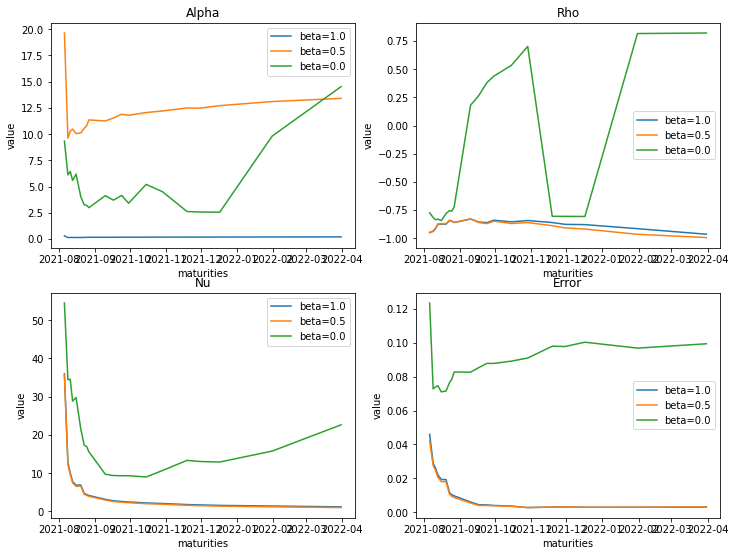

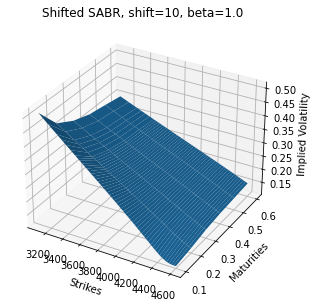

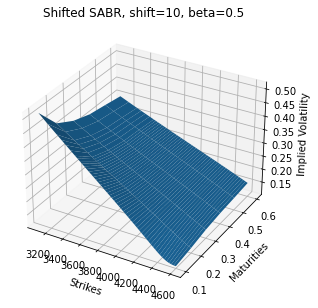

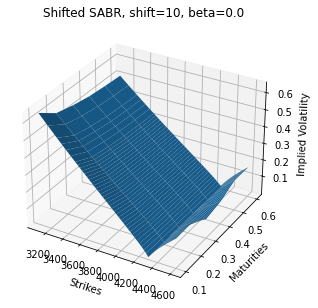

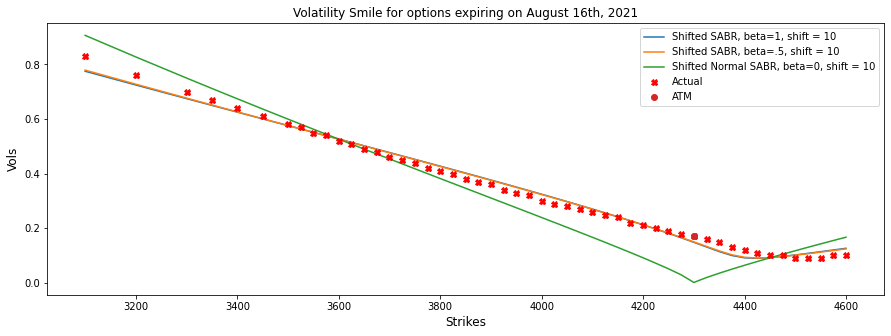

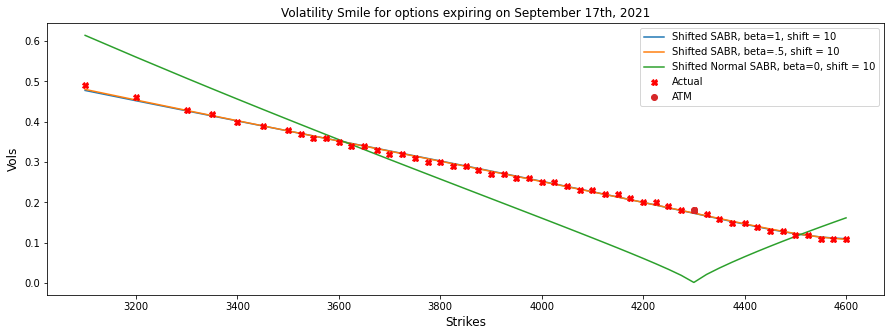

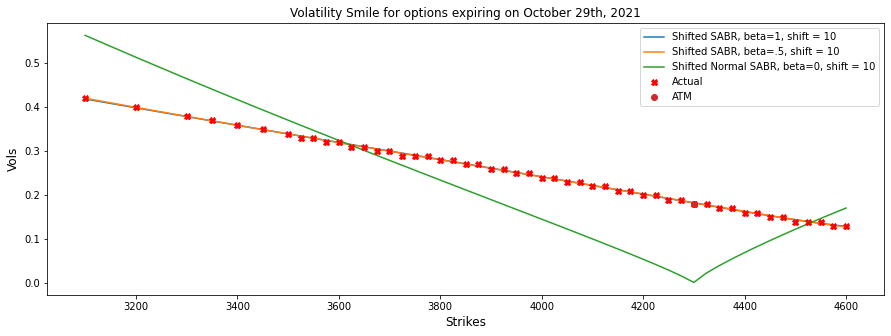

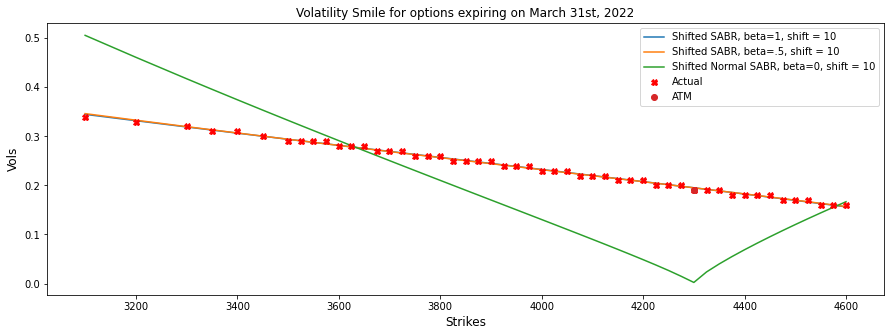

In [267]:
# Shifted SABR Volatility model
shft = 10
shiftedSABR_beta1 = SABRVolatilitySurface(beta=1, shift=shft, label="Shifted SABR, beta=1, shift = {}".format(shft))
shiftedSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=shft, label="Shifted SABR, beta=.5, shift = {}".format(shft))
shiftedSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=shft, label="Shifted Normal SABR, beta=0, shift = {}".format(shft))

SABRComparison([shiftedSABR_beta1, shiftedSABR_beta5, shiftedSABR_beta0], title="Shifted SABR, shift={}".format(shft))

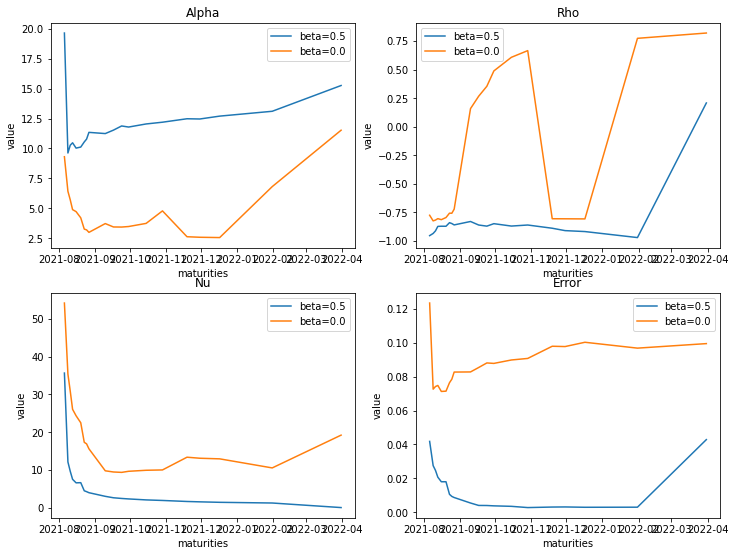

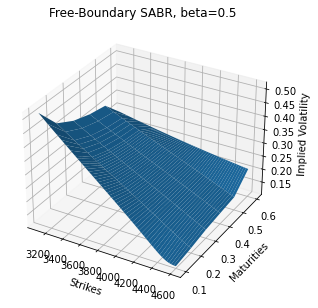

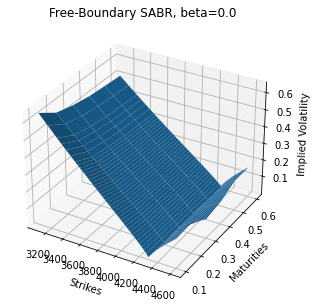

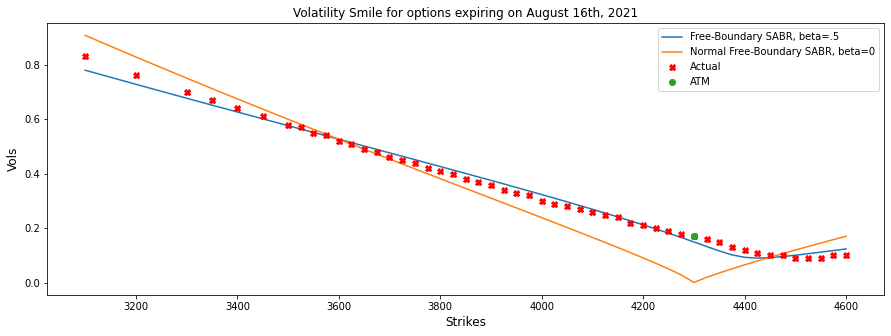

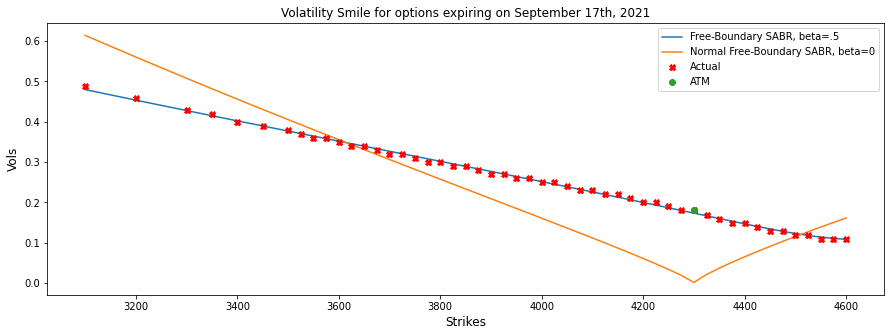

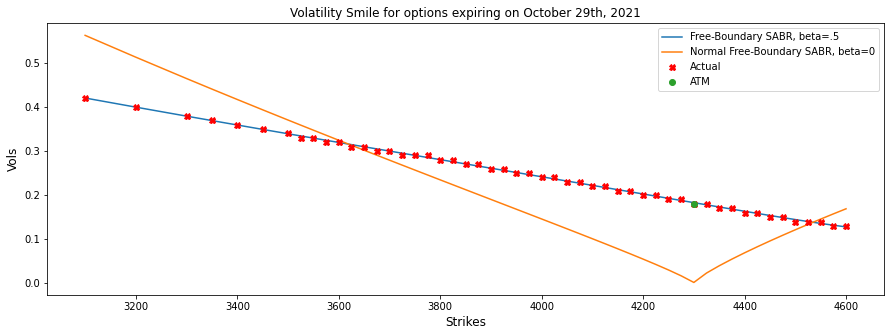

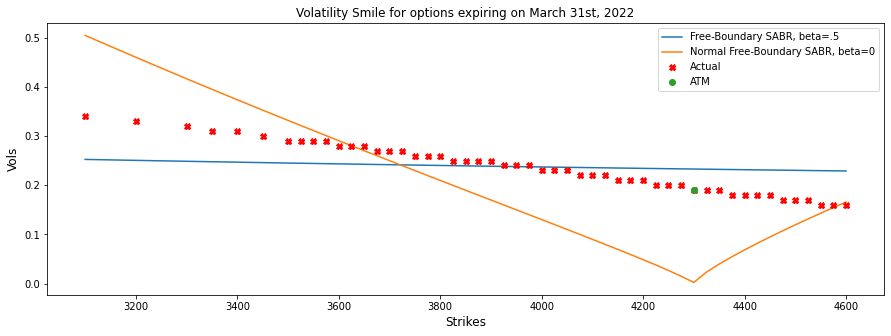

In [268]:
# Free-Boundary SABR Volatility model

freeSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, method="floch-kennedy", label="Free-Boundary SABR, beta=.5")
freeSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, method="floch-kennedy", label="Normal Free-Boundary SABR, beta=0")

SABRComparison([freeSABR_beta5, freeSABR_beta0], title="Free-Boundary SABR")

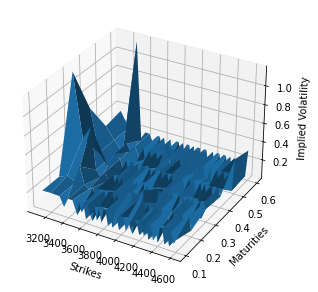

In [269]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

black_var_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
#if does not work use NoExceptLocalVolSurface
# local_vol_surface = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)
local_vol_surface = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, .2)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, funct='localVol')


In [270]:
#HESTON MODEL SURFACE PLOTTING (Levenberg-Marquardt Method)

# Model1
m1_params = (0.02,0.2,0.5,0.1,0.01) if dataframe != "SPX" else (0.05,0.2,0.5,0.1,0.09)
# Model2
m2_params = (0.02,0.2,0.5,0.1,0.01) if dataframe != "SPX" else (0.01,0.5,0.2,0.2,0.06)

class hestonModelSurface:
    def __init__(self, params):
        (self.v0, self.kappa, self.theta, self.sigma, self.rho) = params
        self.hestonModel = None
        self.engine = None
        self.heston_helpers = None
        self.heston_vol_surface = None
        self.strks = None
        self.marketValue = None
        self.modelValue = None
        self.relativeError = None
        self.avgError = None

        self.initialize()

    def initialize(self):
        process = ql.HestonProcess(flat_ts, dividend_ts, 
                                ql.QuoteHandle(ql.SimpleQuote(current_price)), 
                                self.v0, self.kappa, self.theta, self.sigma, self.rho)
        self.hestonModel = ql.HestonModel(process)
        self.engine = ql.AnalyticHestonEngine(self.hestonModel) 

        self.heston_helpers = []
        black_var_surface.setInterpolation("bicubic")
        one_year_idx = -1 
        date = dates[one_year_idx]

        for j, s in enumerate(strikes):
            t = (date - today)
            p = ql.Period(t, ql.Days)
            sigma = vols[one_year_idx][j]

            helper = ql.HestonModelHelper(p, calendar, current_price, s, 
                                        ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                        flat_ts, 
                                        dividend_ts)
            helper.setPricingEngine(self.engine)
            self.heston_helpers.append(helper)

        lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
        self.hestonModel.calibrate(self.heston_helpers, lm, 
                        ql.EndCriteria(500, 300, 1.0e-8, 1.0e-8, 1.0e-8))
        self.v0, self.kappa, self.theta, self.sigma, self.rho = self.hestonModel.params()

        self.set_surface()
        self.compute_errors()

    def set_surface(self):
        # Boilerplate to get to the Vol Surface object
        heston_handle = ql.HestonModelHandle(self.hestonModel)
        self.heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

    def compute_errors(self):
        # Statistical analysis on the Heston model and plotting

        self.strks, self.marketValue, self.modelValue, self.relativeError = ([], [], [], [])

        self.avgError = 0
        for i, opt in enumerate(self.heston_helpers):
            err = (opt.modelValue()/opt.marketValue() - 1.0)
            self.strks.append(strikes[i]); self.marketValue.append(opt.marketValue()); self.modelValue.append(opt.modelValue()); self.relativeError.append(100.0*(opt.modelValue()/opt.marketValue() - 1.0))
            self.avgError += abs(err)
        self.avgError = self.avgError*100.0/len(self.heston_helpers)

hestonModel1 = hestonModelSurface(m1_params)
hestonModel2 = hestonModelSurface(m2_params)


Strikes  Market Value  Model Value  Relative Error (%)
30   4100.0    208.951741   208.740413           -0.101138
31   4125.0    219.849995   215.368484           -2.038441
32   4150.0    217.756167   222.235651            2.057110
33   4175.0    229.197866   229.355426            0.068744
34   4200.0    240.988706   236.742457           -1.762012
35   4225.0    239.470435   244.412626            2.063800
36   4250.0    251.872223   252.383156            0.202854
37   4275.0    264.635524   260.672712           -1.497460
38   4300.0    263.898153   269.301496            2.047511
39   4325.0    252.358752   253.304311            0.374688
40   4350.0    241.190858   237.691670           -1.450796
41   4375.0    216.498721   222.488762            2.766779
42   4400.0    206.092763   207.722417            0.790738
43   4425.0    196.064639   193.420972           -1.348365
44   4450.0    186.408589   179.614009           -3.644993
45   4475.0    163.519417   166.331932            1.719988
46   4500.0    154.710813   153.605336           -0.714544
47   4525.0    146.273218   141.464143           -3.287735
48   4550.0    125.147585   129.936482            3.826599
49   4575.0    117.626639   119.047329            1.207796
50   4600.0    110.468031   108.816982           -1.494594

Value
theta     0.933938
kappa     0.344517
sigma    -0.799062
rho       0.042998
v0        0.256559
avgError  1.772929

No handles with labels found to put in legend.


Strikes  Market Value  Model Value  Relative Error (%)
30   4100.0    208.951741   204.341240           -2.206491
31   4125.0    219.849995   212.520537           -3.333845
32   4150.0    217.756167   220.984330            1.482467
33   4175.0    229.197866   229.702684            0.220254
34   4200.0    240.988706   238.716428           -0.942898
35   4225.0    239.470435   248.000021            3.561853
36   4250.0    251.872223   257.589310            2.269836
37   4275.0    264.635524   267.464275            1.068923
38   4300.0    263.898153   277.655568            5.213153
39   4325.0    252.358752   263.161215            4.280598
40   4350.0    241.190858   248.994510            3.235468
41   4375.0    216.498721   235.144488            8.612414
42   4400.0    206.092763   221.634152            7.540968
43   4425.0    196.064639   208.455398            6.319731
44   4450.0    186.408589   195.628955            4.946320
45   4475.0    163.519417   183.148637           12.004213
46   4500.0    154.710813   171.033643           10.550542
47   4525.0    146.273218   159.279038            8.891457
48   4550.0    125.147585   147.902922           18.182801
49   4575.0    117.626639   136.901247           16.386261
50   4600.0    110.468031   126.291135           14.323695

Value
theta      0.455446
kappa      0.559353
sigma     -1.000000
rho        0.014176
v0         0.220910
avgError  13.631019

No handles with labels found to put in legend.


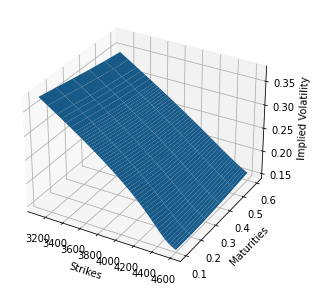

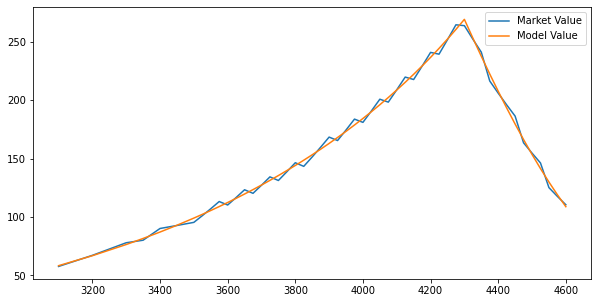

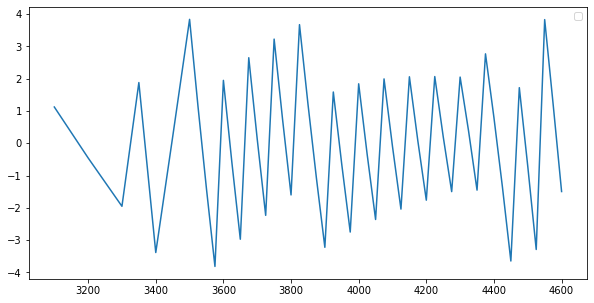

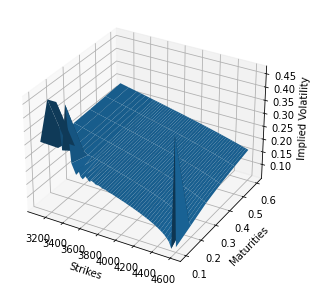

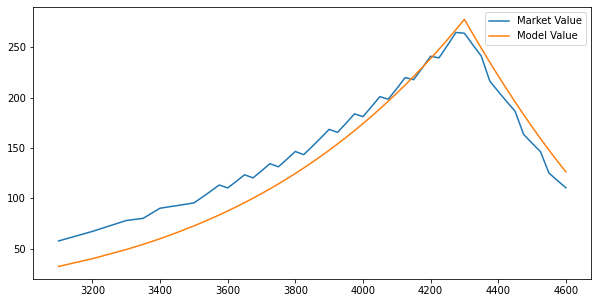

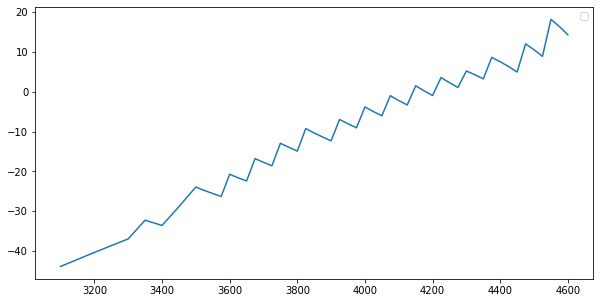

In [271]:
# HESTON Surface Plotting

market_errors1 = pd.DataFrame({"Strikes": hestonModel1.strks, "Market Value": hestonModel1.marketValue, "Model Value": hestonModel1.modelValue, "Relative Error (%)": hestonModel1.relativeError})
variables1 = pd.DataFrame(data=[hestonModel1.theta, hestonModel1.kappa, hestonModel1.sigma, hestonModel1.rho, hestonModel1.v0, hestonModel1.avgError], index=["theta", "kappa", "sigma", "rho", "v0", "avgError"], columns=["Value"])

market_errors2 = pd.DataFrame({"Strikes": hestonModel2.strks, "Market Value": hestonModel2.marketValue, "Model Value": hestonModel2.modelValue, "Relative Error (%)": hestonModel2.relativeError})
variables2 = pd.DataFrame(data=[hestonModel2.theta, hestonModel2.kappa, hestonModel2.sigma, hestonModel2.rho, hestonModel2.v0, hestonModel2.avgError], index=["theta", "kappa", "sigma", "rho", "v0", "avgError"], columns=["Value"])

# Model 1
plot_vol_surface(hestonModel1.heston_vol_surface)
display(market_errors1.iloc[30:]); display(variables1)

figsize = (10, 5)
fig1 = plt.figure(figsize=figsize)
plt.plot(hestonModel1.strks, hestonModel1.marketValue, label="Market Value")
plt.plot(hestonModel1.strks, hestonModel1.modelValue, label="Model Value")
plt.title='Model1: Heston surface Market vs Model Value'; plt.xlabel='strikes'; plt.ylabel='value'
plt.legend()
fig2 = plt.figure(figsize=figsize)
plt.plot(hestonModel1.strks, hestonModel1.relativeError)
plt.title='Model1: Heston surface Relative Error (%)'; plt.xlabel='strikes'; plt.ylabel='value'
plt.legend()

# Model 2
plot_vol_surface(hestonModel2.heston_vol_surface)
display(market_errors2.iloc[30:]); display(variables2)

fig3 = plt.figure(figsize=figsize)
plt.plot(hestonModel2.strks, hestonModel2.marketValue, label="Market Value")
plt.plot(hestonModel2.strks, hestonModel2.modelValue, label="Model Value")
plt.title='Model2: Heston surface Market vs Model Value'; plt.xlabel='strikes'; plt.ylabel='value'
plt.legend()
fig4 = plt.figure(figsize=figsize)
plt.plot(hestonModel2.strks, hestonModel2.relativeError)
plt.title='Model2: Heston surface Relative Error (%)'; plt.xlabel='strikes'; plt.ylabel='value'
plt.legend()


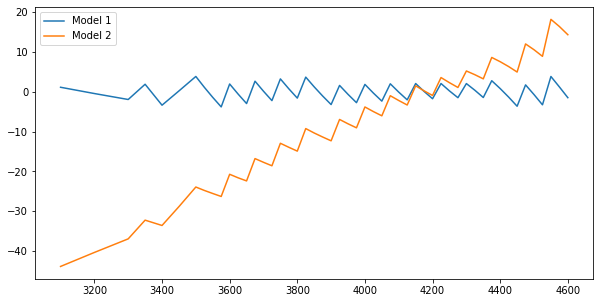

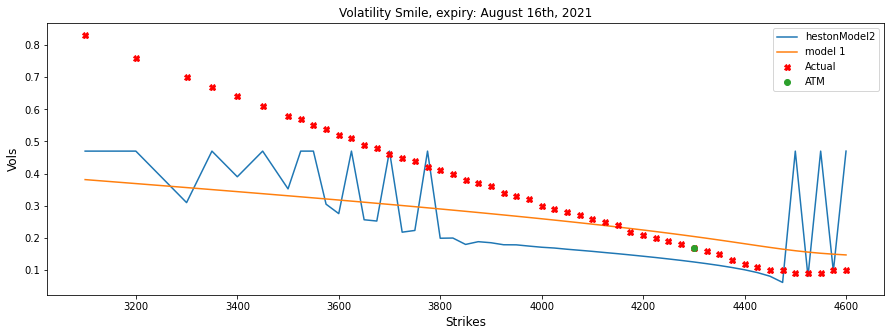

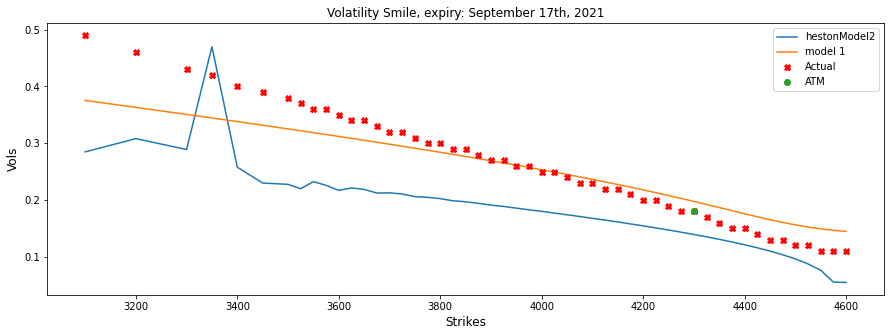

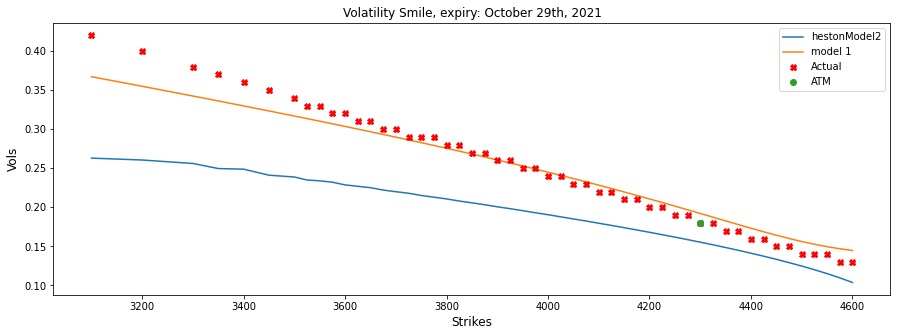

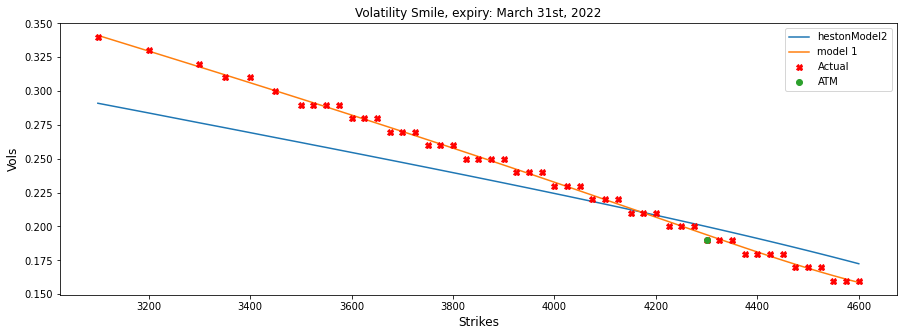

In [272]:
# Relative error comparison
fig5 = plt.figure(figsize=figsize)
plt.plot(hestonModel1.strks, hestonModel1.relativeError, label="Model 1")
plt.plot(hestonModel2.strks, hestonModel2.relativeError, label="Model 2")
plt.title='Model1 vs Model2: Heston surface Relative Error(%)'; plt.xlabel='strikes'; plt.ylabel='value'
plt.legend()

# Volatility smiles comparison
tenors = [dates[round((len(dates)-1) * x)] for x in (.2, .5, .75, 1)]
for tenor in tenors:
    l = [
        ([hestonModel2.heston_vol_surface.blackVol(tenor, s) for s in strikes], "hestonModel2" ),
        ([hestonModel1.heston_vol_surface.blackVol(tenor, s) for s in strikes], "model 1" )
        ]
    plot_smile(tenor, l, market=True, title="Volatility Smile, expiry: {}".format(tenor))

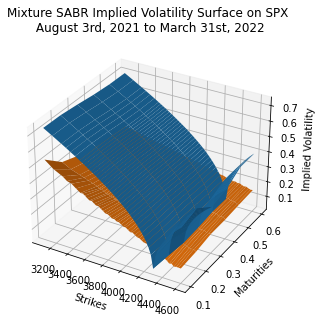

In [274]:
# MIXTURE SABR

class MixtureSABR:
    def __init__(self, zeroFB_SABR, nonzero_SABR):
        self.M = ql.Matrix(51, 20)
        self.zeroFB_SABR = zeroFB_SABR
        self.nonzero_SABR = nonzero_SABR
        
        self.initialize()

    def initialize(self):

        atm_index = strikes.tolist().index(ATM_price)

        for i in range(len(vols)):
            beta_FB = self.zeroFB_SABR.beta[i]
            nu_N = self.nonzero_SABR.nu[i]
            rho_N = self.nonzero_SABR.rho[i]
            
            for j in range(len(vols[i])):

                # sigma_0 = zeroFB_SABR.SABRVolMatrix[i][j] * math.log(current_price)**beta_FB
                # sigma_0 = nonzero_SABR.SABRVolMatrix[i][j]
                sigma_0 = zeroFB_SABR.SABRVolMatrix[atm_index][i]
                p = sigma_0 * beta_FB / ( sigma_0 * beta_FB + abs(nu_N * rho_N) )
                sigma_FB = self.zeroFB_SABR.SABRVolMatrix[j][i]
                sigma_N = self.nonzero_SABR.SABRVolMatrix[j][i]

                self.M[j][i] = math.sqrt((p**2) * sigma_FB +( (1-p)**2) * sigma_N)

        self.vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, self.M, day_count)
        self.vol_surface.enableExtrapolation()

mixtureSABR = MixtureSABR(freeSABR_beta1, SABR_beta0)
title = "Mixture SABR Implied Volatility Surface on {}\n {} to {}".format(dataframe, today, dates[-1])
plot_vol_surface(vol_surface=[mixtureSABR.vol_surface, black_var_surface], plot_strikes=strikes, funct='blackVol', title=title)

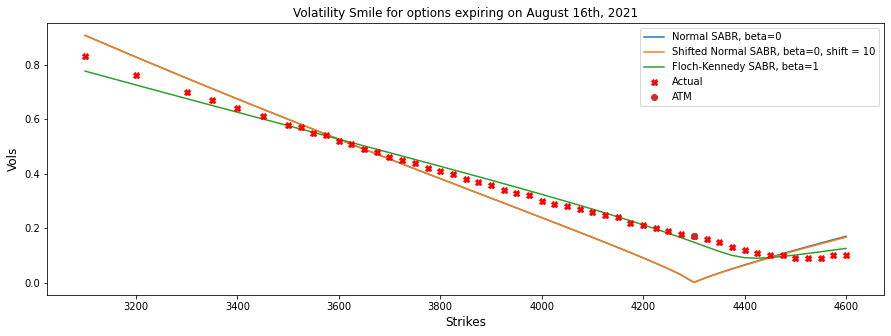

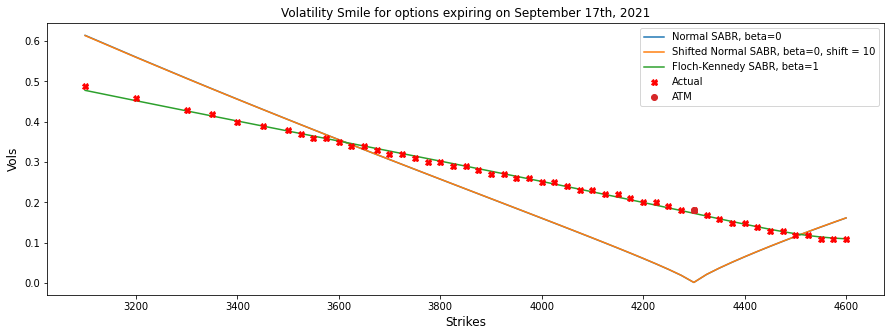

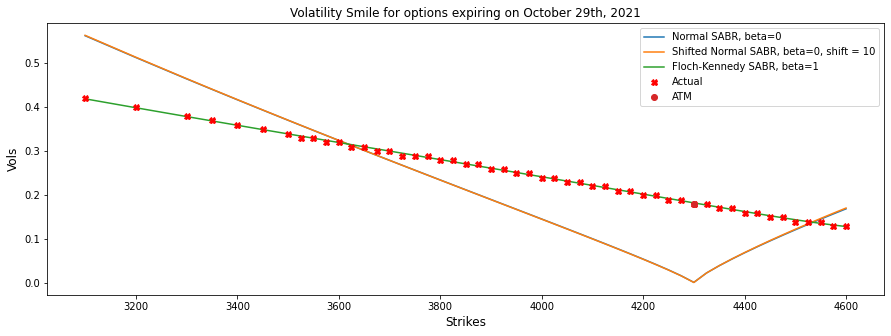

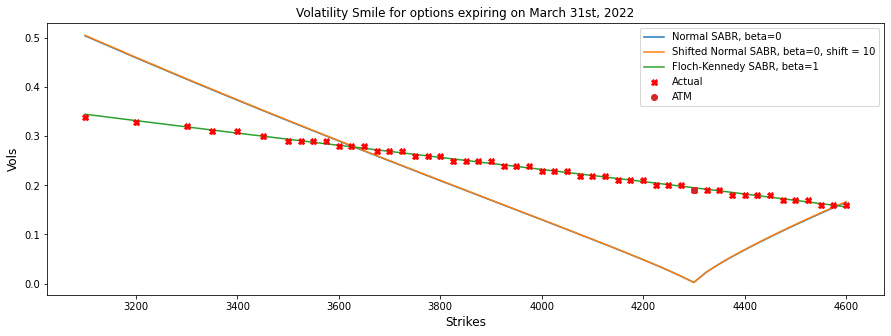

In [275]:
# VOLATILIY SMILES COMPARISON

models = (SABR_beta0, shiftedSABR_beta0, freeSABR_beta1, )

smiles_comparison(models)

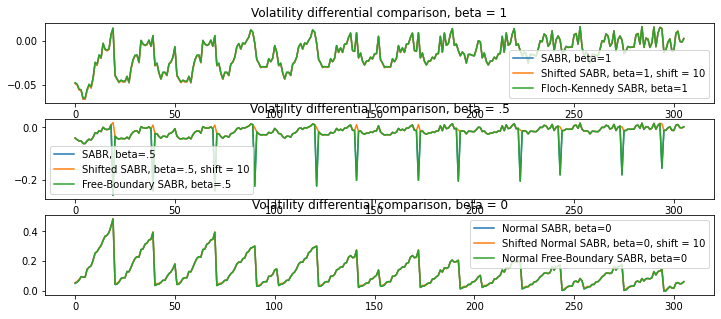

In [276]:
# Volatility differential comparison

def volDiffMatrix(model, part=1.):
    m = []
    for a in range(len(dates)):
        for b in range(len(strikes)):
            m.append(model.SABRVolDiffMatrix[a][b])
    return m [:round((len(m)-1) * part)]

fig, axs = plt.subplots(3, 1, figsize=plot_size)
for model in (SABR_beta1, shiftedSABR_beta1, freeSABR_beta1):
    v = volDiffMatrix(model, .3)
    axs[0].plot(v, label=model.label)
    axs[0].set_title("Volatility differential comparison, beta = 1")
axs[0].legend()

for model in (SABR_beta5, shiftedSABR_beta5, freeSABR_beta5):
    v = volDiffMatrix(model, .3)
    axs[1].plot(v, label=model.label)
    axs[1].set_title("Volatility differential comparison, beta = .5")
axs[1].legend()

for model in (SABR_beta0, shiftedSABR_beta0, freeSABR_beta0):
    v = volDiffMatrix(model, .3)
    axs[2].plot(v, label=model.label)
    axs[2].set_title("Volatility differential comparison, beta = 0")
axs[2].legend()


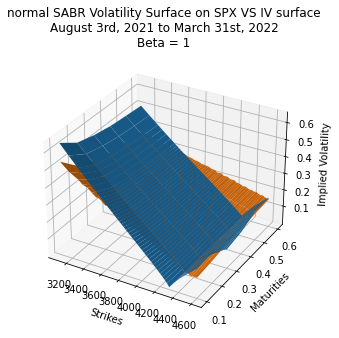

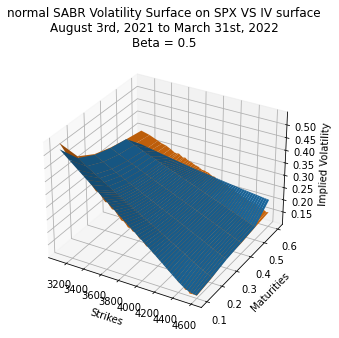

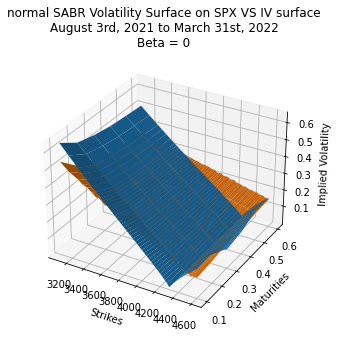

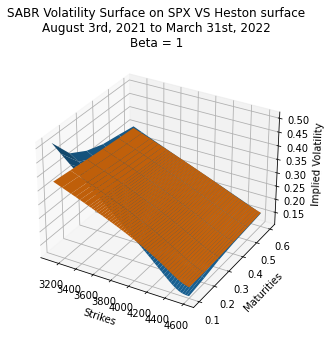

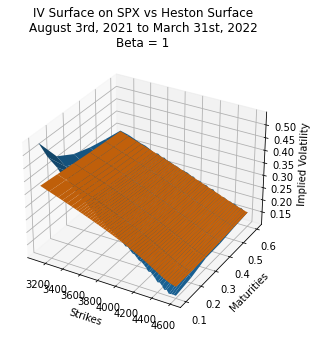

In [283]:
title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 1".format(dataframe, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0.5".format(dataframe, today, dates[-1])
plot_vol_surface([SABR_beta5.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0".format(dataframe, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "SABR Volatility Surface on {} VS Heston surface\n{} to {}\nBeta = 1".format(dataframe, today, dates[-1])
plot_vol_surface([SABR_beta1.vol_surface, hestonModel1.heston_vol_surface], title=title)

title = "IV Surface on {} vs Heston Surface\n{} to {}\nBeta = 1".format(dataframe, today, dates[-1])
plot_vol_surface([black_var_surface, hestonModel1.heston_vol_surface], title=title)